<a href="https://colab.research.google.com/github/SiLiKhon/MLatNLCS2024/blob/main/adversarial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

weights = EfficientNet_V2_S_Weights.IMAGENET1K_V1
model = efficientnet_v2_s(weights=weights)
model.eval()
preprocess = weights.transforms()

In [2]:
from torchvision.io import decode_image

# image from: https://www.pexels.com/photo/a-goldfish-in-a-plastic-bag-8434694/
img = decode_image("pexels-mart-production-8434694.jpg")

prep_img = preprocess(img)

In [3]:
print("Before preprocessing:")
print(f"{img.shape=}")
print(f"{img.dtype=}")
print(f"{img.min()=}")
print(f"{img.max()=}")

print("\nAfter preprocessing:")
print(f"{prep_img.shape=}")
print(f"{prep_img.dtype=}")
print(f"{prep_img.min()=}")
print(f"{prep_img.max()=}")

Before preprocessing:
img.shape=torch.Size([3, 427, 640])
img.dtype=torch.uint8
img.min()=tensor(0, dtype=torch.uint8)
img.max()=tensor(255, dtype=torch.uint8)

After preprocessing:
prep_img.shape=torch.Size([3, 384, 384])
prep_img.dtype=torch.float32
prep_img.min()=tensor(-1.9482)
prep_img.max()=tensor(2.6400)


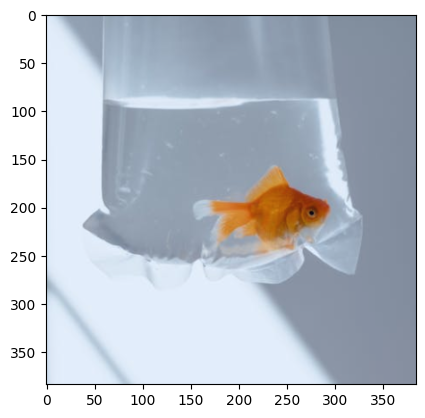

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_img(img, normalize=True):
    img = img.detach().numpy()
    if normalize:
        img = (img - img.min()) / (img.max() - img.min())
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)

plot_img(prep_img)

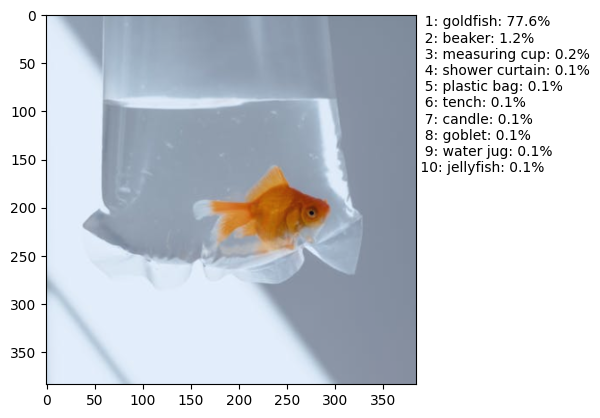

In [5]:
def predict_for_img(img, top_n=10):
    prediction = model(img.unsqueeze(0)).squeeze(0).softmax(0)

    top_ids = prediction.argsort(descending=True)[: top_n]
    prob_strings = []
    for i, class_id in enumerate(top_ids, 1):
        score = prediction[class_id].item()
        category_name = weights.meta["categories"][class_id]
        prob_strings.append(f"{i:3d}: {category_name}: {100 * score:.1f}%")

    plot_img(img)
    plt.text(img.shape[1], 0, "\n".join(prob_strings), va="top")

predict_for_img(prep_img)

 22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

Reached high probability. Stopping...


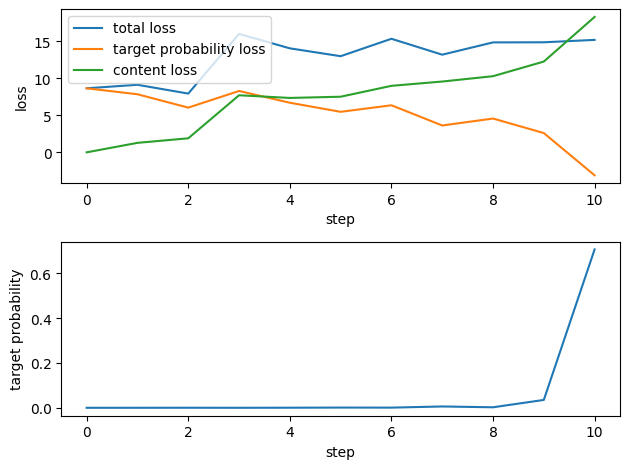

In [13]:
import torch
from tqdm import trange

target_category = "zucchini"
target_id = weights.meta["categories"].index(target_category)

max_steps = 50

original_img = preprocess(img).clone()
adversarial_img = original_img.clone().detach()
adversarial_img.requires_grad = True

history = {
    "total loss": [],
    "target probability": [],
    "target probability loss": [],
    "content loss": [],
}
for _ in trange(max_steps):
    scores = model(adversarial_img.unsqueeze(0)).squeeze(0)
    target_probability = scores.softmax(0)[target_id].item()
    if target_probability >= 0.8:
        print("Reached high probability. Stopping...")
        break

    target_loss = torch.concatenate(
        [scores[:target_id], scores[target_id + 1:]]
    ).max() - scores[target_id]
    content_loss = (adversarial_img - original_img).norm()
    loss = target_loss + content_loss
    loss.backward()
    with torch.no_grad():
        adversarial_img.data -= adversarial_img.grad.data
    adversarial_img.grad.zero_()
    model.zero_grad()

    history["target probability"].append(target_probability)
    history["target probability loss"].append(target_loss.item())
    history["content loss"].append(content_loss.item())
    history["total loss"].append(loss.item())


plt.subplot(2, 1, 1)
for k, v in history.items():
    if k == "target probability": continue
    plt.plot(v, label=k)
plt.xlabel("step")
plt.ylabel("loss")
plt.legend();
plt.subplot(2, 1, 2)
plt.plot(history["target probability"])
plt.xlabel("step")
plt.ylabel("target probability")
plt.tight_layout();

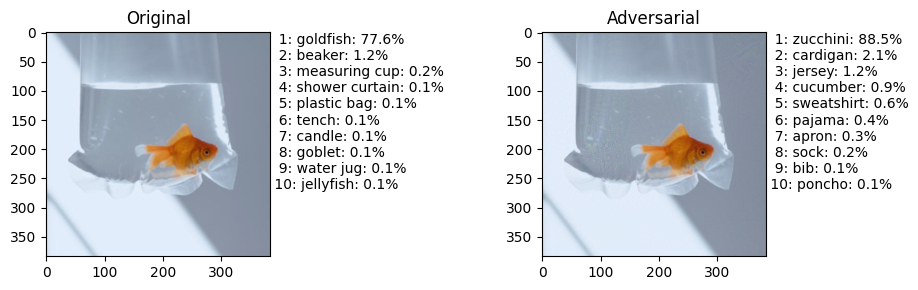

In [14]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.title("Original")
predict_for_img(original_img)

plt.subplot(1, 2, 2)
plt.title("Adversarial")
predict_for_img(adversarial_img)

plt.tight_layout();

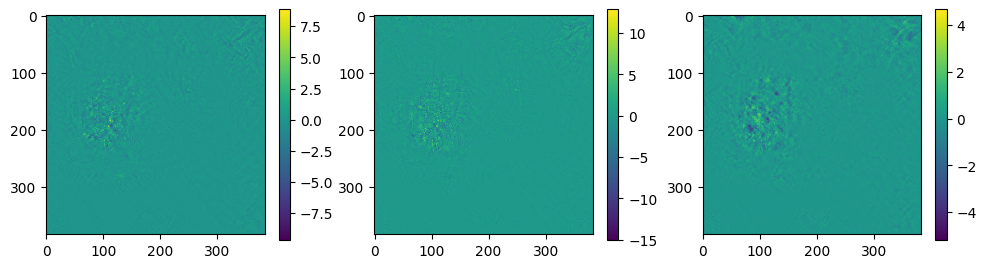

In [15]:
plt.figure(figsize=(12, 3))
for channel in range(3):
    plt.subplot(1, 3, channel + 1)
    dynamic_range = original_img[channel].max() - original_img[channel].min()
    diff = (
        (adversarial_img.detach()[channel] - original_img[channel])
        / dynamic_range * 100
    ).numpy()
    plt.imshow(diff)
    plt.colorbar()

In [9]:
### Uncomment and execute to print all available categories

# from IPython.display import Markdown
# Markdown(
#     "## All categories\n\n"
#     + ", ".join(weights.meta["categories"])
# )